In [1]:
# import all the things!
import gym
import random
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
# froms
from collections import defaultdict
from IPython import display
from itertools import combinations, combinations_with_replacement, permutations

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


[-0.00990324  1.3967583  -0.4935295  -0.327408    0.00900647  0.06411727
  0.          0.        ]


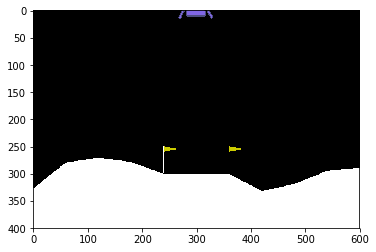

In [2]:
# test lunar lander
env = gym.make('LunarLander-v2')
env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for i in range(1):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    obs, reward, done, info = env.step(env.action_space.sample()) # take a random action
    print(obs)
    if done:
        break
env.close()

In [3]:
def factor_rewards_sequence(n, gamma):
    last    = np.power(gamma, n - 1)
    factors = np.geomspace(1, last, num=n)
    return factors

def discounted_reward(gamma, rewards, discounts):
    # pick last rewards
    n = len(discounts)
    drewards = rewards[-n:] * discounts
    return np.sum(drewards)
    
def episode_discounted_rewards(gamma, rewards):
    N         = len(rewards)
    discounts = factor_rewards_sequence(N, gamma)
    values    = [discounted_reward(gamma, rewards, discounts[:(i + 1)]) for i in range(N)][::-1]
    return np.asarray(values)

def normalized_batch_discounted_rewards(gamma, rewards_in):
    drewards      = [episode_discounted_rewards(gamma, ep_rds) for ep_rds in rewards_in]
    flat_drewards = np.concatenate(drewards)
    mean   = flat_drewards.mean()
    std    = flat_drewards.std()
    values = [(dreward - mean)/std for dreward in drewards]
    return values

In [4]:
# build the network here
def get_model_MCPGBaseline(n_inputs, 
                           n_common,
                           n_hidden_p, 
                           n_hidden_v, 
                           n_actions, 
                           learn_rate=1e-2, 
                           regulw=1e-4, 
                           stop_grad=True,
                           act_hidn=tf.nn.elu
                          ):
    
    # a placeholder allows for later arbitrary subs, which we need
    x      = tf.placeholder  (tf.float32, shape=(None, n_inputs), name='x'  ) # input tensor
    y      = tf.placeholder  (tf.int32,   shape=(None, ),         name='y'  ) # sampled action by index
    dr     = tf.placeholder  (tf.float32, shape=(None, ),         name='dr' ) # discounted rewards
    gamts  = tf.placeholder  (tf.float32, shape=(None, ),         name='gts') # discounted case (gammas)
    
    # com
    if len(n_common):
        netcm = tf.contrib.layers.fully_connected(x, 
                                                  n_common[0], 
                                                  act_hidn, 
                                                  biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                                  weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                                  biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                                  )
        for i in range(len(n_common) - 1):
            netcm = tf.contrib.layers.fully_connected(netcm, 
                                                      n_common[i + 1], 
                                                      act_hidn, 
                                                      biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                                      weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                                      biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                                     )
    else:
        netcm = x
            
    # POLICY NETWORK
    if len(n_hidden_p):
        netpg = tf.contrib.layers.fully_connected(netcm, 
                                                  n_hidden_p[0], 
                                                  act_hidn, 
                                                  biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                                  weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                                  biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                                 )
        for i in range(len(n_hidden_p) - 1):
            netpg = tf.contrib.layers.fully_connected(netpg, 
                                                      n_hidden_p[i + 1], 
                                                      act_hidn, 
                                                      biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                                      weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                                      biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                                     )
    else:
        netpg = netcm
    # activations before softmax, act must be None
    logits = tf.contrib.layers.fully_connected(netpg, 
                                               n_actions, 
                                               None, 
                                               biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                               weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                               biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                              )
    
    # VALUE NETWORK
    if len(n_hidden_v):
        netvf = tf.contrib.layers.fully_connected(netcm, 
                                                  n_hidden_v[0], 
                                                  act_hidn, 
                                                  biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                                  weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                                  biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                                 )
        for i in range(len(n_hidden_v) - 1):
            netvf = tf.contrib.layers.fully_connected(netvf, 
                                                      n_hidden_v[i + 1], 
                                                      act_hidn, 
                                                      biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                                      weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                                      biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                                     )
    else:
        netvf = netcm
    # estimated value function baseline, act must be None
    valuef = tf.contrib.layers.fully_connected(netvf, 
                                               1, 
                                               None, 
                                               biases_initializer=tf.contrib.layers.xavier_initializer(seed=0),
                                               weights_regularizer=tf.contrib.layers.l2_regularizer(regulw),
                                               biases_regularizer=tf.contrib.layers.l2_regularizer(regulw)
                                              )
    
    # POLICY LOSS
    probs  = tf.nn.softmax(logits - tf.reduce_max(logits, 1, keepdims=True), name='probs')
    cross  = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)    
    if stop_grad:
        losspg = tf.reduce_mean(gamts * (cross * tf.stop_gradient(dr - valuef)), name='losspg')
    else:
        losspg = tf.reduce_mean(gamts * (cross * (dr - valuef)), name='losspg')
        
    # VALUE LOSS
    lossvf = tf.losses.absolute_difference(labels=tf.reshape(dr, (-1, 1)), predictions=valuef)
    # LOSS
    loss   = lossvf + losspg + tf.losses.get_regularization_loss()
    optim  = tf.train.AdamOptimizer(learn_rate).minimize(loss)
    # into dict
    model  = { 'x':x, 'y':y, 'dr':dr, 'gamts':gamts, 'logits':logits, 'probs':probs, 'loss':loss, 'optim':optim }
    return model   

In [5]:
# model is model
# ep_obs are episode observations of the form [ [], [], [], ... ]
# ep_rds are episode rewards
# eps_actions are episode sampled actions (as indeces)
def train_network_episode(model, ep_obs, ep_rds, eps_actions, n_actions):
    net_obs     = np.vstack(ep_obs)       # multdim in tensor
    net_drds    = np.asarray(ep_rds)      # 1 dim in tensor
    net_actions = np.asarray(eps_actions) # 1 dim actions
    # to be deprecated... replaced by eligibility
    net_gamts   = np.asarray([1. for i in range(len(ep_rds))])
    # train the network 
    sess.run(model['optim'], feed_dict={
             model[    'x']: net_obs,
             model[    'y']: net_actions,
             model[   'dr']: net_drds,
             model['gamts']: net_gamts
        })

In [6]:
def estimate_action(model, obs):
    obs    = obs[np.newaxis, :]
    probs  = sess.run(model['probs'], feed_dict = {model['x']: obs})
    probs  = probs.ravel()
    return (np.random.choice(len(probs), 1, p=probs))[0]

In [7]:
def episode_rollout_kernel(env, model, max_steps=9999, show=False):
    states  = []
    actions = []
    rewards = []
    # get initial state
    obs = env.reset()
    if show:
        img = plt.imshow(env.render(mode='rgb_array'))
    # rollout episode
    i = 0
    for i in range(max_steps):
        if show:
            img.set_data(env.render(mode='rgb_array'))
            display.display(plt.gcf())
            display.clear_output(wait=True)
        # using the current (pre step) state of the world
        x = obs
        # save it into history
        states.append(x)
        # estimate action to take given our policy
        action = estimate_action(model, x)
        # save it into history as well (the index)
        actions.append(action)
        # perform the action and save the reward
        obs, reward, done, info = env.step(action)
        rewards.append(reward)        
        # look for end, no appends beyond it ONCE
        if done:
            if show:
                env.close()
            break
    sum_reward = np.sum(rewards)
    avg_reward = sum_reward / i
    return states, rewards, actions, sum_reward, avg_reward, i

In [8]:
sess = tf.Session()
# set all seeds
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

model = get_model_MCPGBaseline(n_inputs  =8,
                               n_common  =[],
                               n_hidden_p=[10, 10], 
                               n_hidden_v=[10], 
                               n_actions =4, 
                               learn_rate=1e-2, 
                               regulw    =1e-5, 
                               stop_grad =True,
                               act_hidn  =tf.nn.tanh
                               )
#"""
sess.run(tf.global_variables_initializer())

In [9]:
batch_size = 10
n_batches  = 1000

In [11]:
global_rds          = []
global_iters        = []
# per batch data
batched_avgtotalrds = []
batched_avgavgrds   = []
batched_stdtotalrds = []
batched_avgiters    = []
batched_mintotalrds = []
batched_maxtotalrds = []

for N in range(n_batches):
    
    batch_obs   = []
    batch_rds   = []
    batch_acts  = []
    batch_sums  = []
    batch_iters = []
    
    for n in range(batch_size):
        
        ep_obs, ep_rds, ep_actions, sum_reward, avg_reward, iters = episode_rollout_kernel(env, model)
        # save globals
        global_rds.append(ep_rds)
        global_iters.append(iters)
        
        batch_obs  += ep_obs
        batch_rds.append(ep_rds)
        batch_acts += ep_actions
        batch_sums.append(sum_reward)
        batch_iters.append(iters)
        
    batch_nrds = np.concatenate(normalized_batch_discounted_rewards(0.999, batch_rds))
    train_network_episode(model, batch_obs, batch_nrds, batch_acts, 4)
    
    # save globals
    batched_avgtotalrds.append(np.mean(batch_sums))
    batched_avgavgrds.append  (np.mean(np.concatenate(batch_rds)))
    batched_stdtotalrds.append(np.std(batch_sums))
    batched_avgiters.append   (np.mean(batch_iters))
    batched_mintotalrds.append(np.min(batch_sums))
    batched_maxtotalrds.append(np.max(batch_sums))
    
    print(f'Episode {N + 1} with avg total reward {np.mean(batch_sums)} std dev {np.std(batch_sums)} min {np.min(batch_sums)} max {np.max(batch_sums)} avg avg reward {np.mean(np.concatenate(batch_rds))} took avg iters {np.mean(batch_iters)}    ', flush=True, end='\r')

KeyboardInterrupt: 

In [ ]:
# test the final model
_, _, _, _, _, _ = episode_rollout_kernel(env, model, kernel=kernel, show=True)